# References and global variables

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.sys.path.append('../fastai/') #fastai version 1

from pathlib import Path
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary

import fastai
from fastai import *
from fastai.vision import *
from fastai.vision.image import *


DP = Path('/home/Deep_Learner/work/network/datasets/human-protein-atlas-image-classification/')
STAGE_ONE_DATA = DP/'stage1_data'
TRAIN_PNGS = 'base_and_extra_data_pngs_512'
TEST_PNGS = 'test_pngs_512'
TRAIN_CSV = 'base_and_extra_data_without_broken_and_missing.csv'
SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
SUBMISSIONS = DP/STAGE_ONE_DATA/'submissions'
SUBMISSIONS.mkdir(exist_ok=True)

IdToCatDict = {0:'Nucleoplasm',
               1:'Nuclear_membrane',
               2:'Nucleoli',
               3:'Nucleoli_fibrillar_center',
               4:'Nuclear_speckles',
               5:'Nuclear_bodies',
               6:'Endoplasmic_reticulum',
               7:'Golgi_apparatus',
               8:'Peroxisomes',
               9:'Endosomes',
               10:'Lysosomes',
               11:'Intermediate_filaments',
               12:'Actin_filaments',
               13:'Focal_adhesion_sites',
               14:'Microtubules',
               15:'Microtubule_ends',
               16:'Cytokinetic_bridge',
               17:'Mitotic_spindle',
               18:'Microtubule_organizing_center',
               19:'Centrosome',
               20:'Lipid_droplets',
               21:'Plasma_membrane',
               22:'Cell_junctions',
               23:'Mitochondria',
               24:'Aggresome',
               25:'Cytosol',
               26:'Cytoplasmic_bodies',
               27:'Rods_&_rings'}

sz = 512
bs = 4
val_split = 0.2
np.random.seed(42)
torch.cuda.set_device(1)

# Data

In [2]:
def open_4_channel(fname):
    try:
        fname = str(fname)
        # strip extension before adding color
        if fname.endswith('.png'):
            fname = fname[:-4]
        colors = ['red','green','blue','yellow']
        flags = cv2.IMREAD_GRAYSCALE
        img = [cv2.imread(fname+'_'+color+'.png', flags).astype(np.float32)/255
               for color in colors]
        
        x = np.stack(img, axis=-1)
        return Image(pil2tensor(x, np.float32).float())
    except: 
        print(fname)

src = (ImageItemList.from_csv(STAGE_ONE_DATA, TRAIN_CSV, folder=TRAIN_PNGS, suffix='.png')
       .random_split_by_pct(val_split)
       .label_from_df(sep=' ',  classes=[str(i) for i in range(28)]))

src.train.x.create_func = open_4_channel
src.valid.x.create_func = open_4_channel
src.train.x.open = open_4_channel
src.valid.x.open = open_4_channel

test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(STAGE_ONE_DATA/TEST_PNGS)}))
test_fnames = [STAGE_ONE_DATA/TEST_PNGS/test_fn for test_fn in test_ids]
src.add_test(test_fnames, label='0')
src.test.x.create_func = open_4_channel
src.test.x.open = open_4_channel

#protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814]) #base data
protein_stats = ([0.05667, 0.05236, 0.03232, 0.0971 ],[0.09171, 0.08472, 0.08758, 0.14375]) # base and extra data

trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.05, max_warp=0.)

data = (src.transform((trn_tfms, _), size=sz)
        .databunch(bs=bs).normalize(protein_stats))

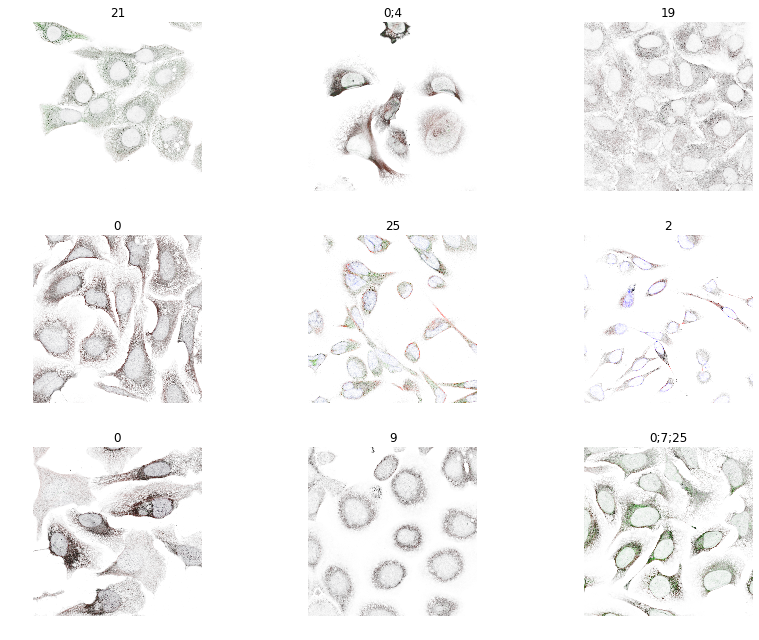

In [12]:
data.show_batch(rows=3, figsize=(12,9))

# Loss Function/Metrics

In [3]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()


f1_score = partial(fbeta, thresh=0.5, beta=1)

# Model

In [4]:
RESNET_ENCODERS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}

class Resnet4Channel(nn.Module):
    def __init__(self,  pretrained=True, encoder_depth=50, num_classes=28):
        super().__init__()

        encoder = RESNET_ENCODERS[encoder_depth](pretrained=pretrained)
        
        w = encoder.conv1.weight
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        #self.conv1.weight = nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1))
        self.conv1.weight = torch.nn.Parameter(torch.cat((w,w[:,:1,:,:]),dim=1))
        
        self.bn1 = encoder.bn1
        self.relu = nn.ReLU(inplace=True) 
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4
        
        self.avgpool = encoder.avgpool
        self.fc = nn.Linear(512 * (1 if encoder_depth==34 else 4), num_classes)        
        
        ##not giving a good score
        #self.custom_head = fastai.vision.learner.create_head(nf = 512 * (1 if encoder_depth==34 else 4)*2, nc = num_classes)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        ##not giving a good score        
        #x = self.custom_head(x)
        
        return x

def resnet50(pretrained):
    return Resnet4Channel(pretrained=pretrained, encoder_depth=50)

# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): 
    return (m[0][6],m[1])

# Train

In [5]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = Resnet4Channel(50).to(device)
#model
#summary(model, (4, sz, sz))

In [6]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    #loss_func=F.binary_cross_entropy_with_logits,
    loss_func = FocalLoss(),
    path=STAGE_ONE_DATA,    
    metrics=[f1_score], 
)

In [7]:
learn.summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList
y: MultiCategoryList (84530 items)
[MultiCategory 16;0, MultiCategory 7;1;2;0, MultiCategory 5, MultiCategory 1, MultiCategory 18]...
Path: /home/Deep_Learner/work/network/datasets/human-protein-atlas-image-classification/stage1_data
x: ImageItemList (84530 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: /home/Deep_Learner/work/network/datasets/human-protein-atlas-image-classification/stage1_data;

Valid: LabelList
y: MultiCategoryList (21132 items)
[MultiCategory 25;11, MultiCategory 13;7, MultiCategory 25;21, MultiCategory 0, MultiCategory 7;0;21]...
Path: /home/Deep_Learner/work/network/datasets/human-protein-atlas-image-classification/stage1_data
x: ImageItemList (21132 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: /home/Deep_Learner/work/network/datasets/hu

In [8]:
learn.lr_find()

RuntimeError: CUDA error: out of memory

In [ ]:
learn.recorder.plot()

In [20]:
lr = 1e-1

In [24]:
learn.fit_one_cycle(20, slice(lr))

Total time: 1:42:50
epoch  train_loss  valid_loss  fbeta    
1      0.166507    0.169505    0.082455   (05:08)
2      0.169886    0.367041    0.188674   (05:07)
3      0.173509    2137.328125  0.159403  (05:05)
4      0.184185    19.522430   0.259109   (05:10)
5      0.204276    3.654228    0.013249   (05:08)
6      0.220206    4671.480957  0.034348  (05:08)
7      0.200705    936.429565  0.028875   (05:09)
8      0.196299    0.241009    0.253770   (05:08)
9      0.185453    1.045191    0.324202   (05:08)
10     0.180938    6361.982910  0.184979  (05:09)
11     0.175172    0.176103    0.348905   (05:09)
12     0.173705    0.167588    0.216727   (05:07)
13     0.164847    2.019491    0.273615   (05:09)
14     0.155390    0.167999    0.296350   (05:09)
15     0.150807    0.204263    0.281296   (05:09)
16     0.148605    0.196750    0.184950   (05:07)
17     0.138646    0.164029    0.352107   (05:08)
18     0.136981    0.139933    0.407285   (05:09)
19     0.133402    0.142661    0.398346

In [25]:
learn.save()

# Predictions

In [26]:
preds,_ = learn.get_preds(DatasetType.Test)

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1129: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [27]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':df_test.Id,'Predicted':pred_labels})
df.to_csv(SUBMISSIONS/'resnet50_sz224_bs64_fastaiCustomHead.csv', header=True, index=False)